# Модель обнаружения отклонений в ИП

In [1]:
from __future__ import division

Подключаем основные библиотеки для работы с данными

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

## Загрузка данных
Показания сенсоров храняться в одном csv файле. В качестве индекса используется столбце времени *time*

In [3]:
train = pd.read_csv('/media/volume/datasets/UpAndDown/train.csv', index_col='time')

## Описание

Точек по времени

In [4]:
N = len(train)
N

502404

Размерность временного ряда

In [5]:
K = len(train.columns)
K

269

Размер занимаемой RAM (Гб)

In [6]:
print("{:.2f}".format(train.memory_usage(index=True).sum()/2**30))

1.01


## Визуализация данных
Для визуализации выберем из всего набора несколько основных рядов

In [7]:
columns_to_plot = [
    'tank.level',
    'valveDiscrete1.open',
    'valveDiscrete1.V_flow',
    'valveDiscrete2.open',
    'valveDiscrete2.V_flow',
]

Построим графики для выбранных временных рядов на первых 

In [8]:
end_plot = 10000

точках

<IPython.core.display.Javascript object>


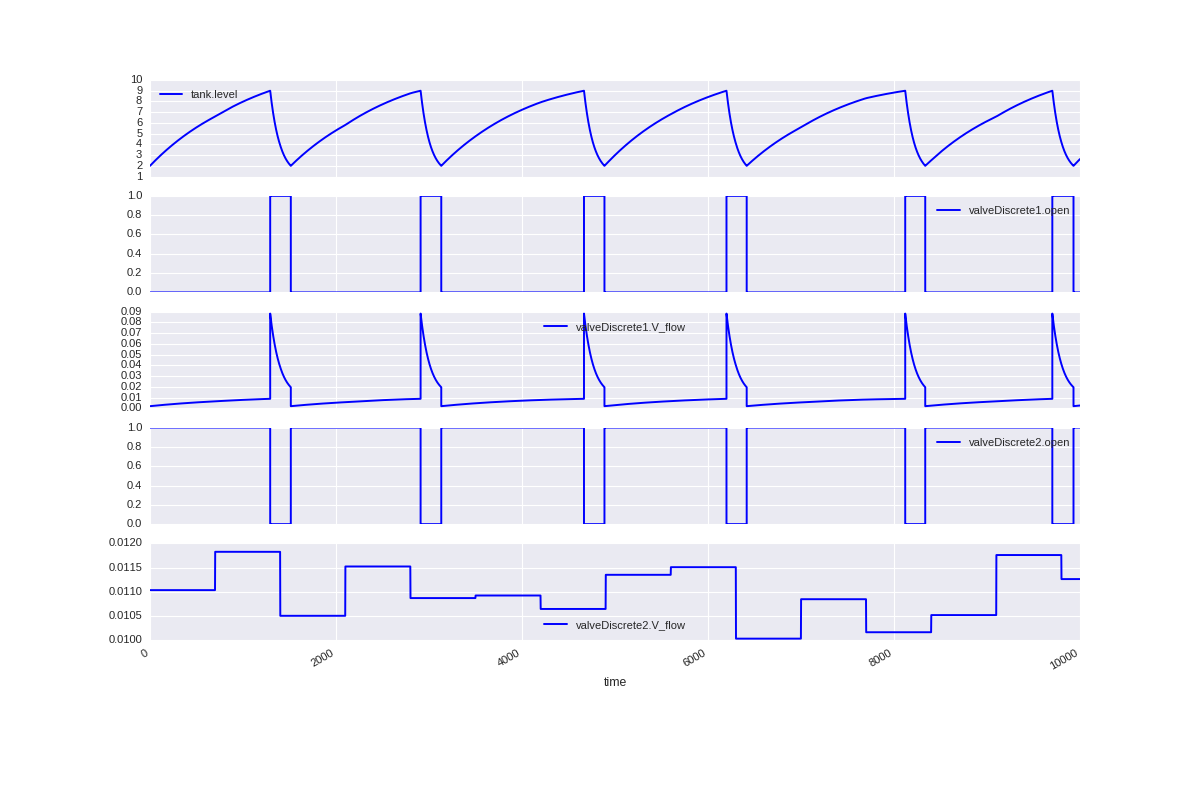

In [37]:
_ = train[columns_to_plot][:end_plot].plot(subplots=True, figsize=(15,10), color='blue')


### Предобработка данных

Поскольку для построения прогноза будут использоваться нейронные сети, то необходимо нормализовать все временные ряды. Для этого будет использовать инструменты библиотеки sklearn

In [10]:
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
train_scaled = pd.DataFrame(data=standart_scaler.fit_transform(train), index=train.index, columns=train.columns)

### Визуализируем результат нормализации

<IPython.core.display.Javascript object>


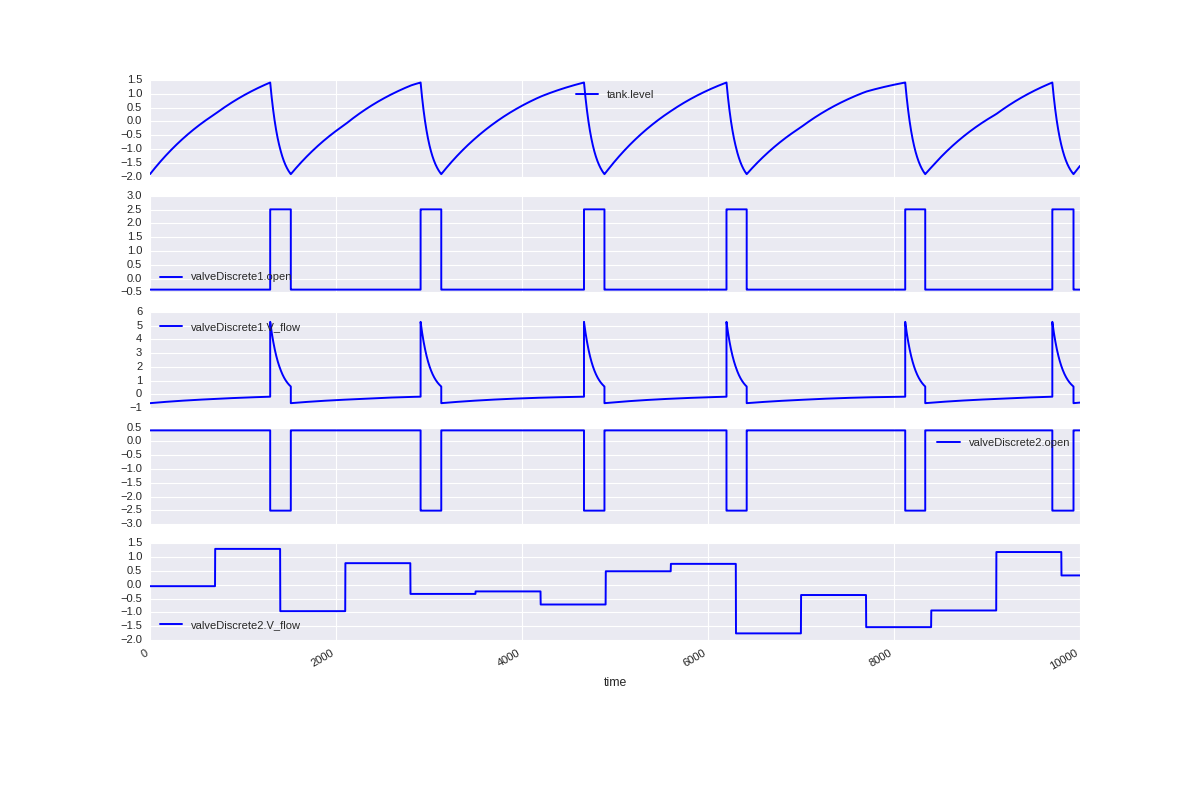

In [38]:
_ = train_scaled[columns_to_plot][:end_plot].plot(subplots=True, figsize=(15,10), color='blue')

### Разделение данных на обучающую и проверочную выборки

Пусть доля проверочной выборки составляет

In [12]:
validation_split = 0.1

Число точек в обучающей выборке

In [13]:
train_size = int(math.floor(N*(1 - validation_split)))
train_size

452163

Число точек в проверочной выборке

In [14]:
validation_size = int(math.ceil(N*validation_split))
validation_size

50241

In [15]:
assert(validation_size + train_size == N)

In [16]:
train_dataset = train_scaled.iloc[:train_size]
validation_dataset = train_scaled.iloc[train_size:]

Будем обрабатывать данные окнами по

In [17]:
window_size = 60

точек.

In [18]:
def crop(dataset, window_size):
    crop_size = len(dataset) - len(dataset) % window_size
    return dataset.iloc[:crop_size].values.reshape(-1, window_size, K)

In [19]:
train_reshaped = crop(train_dataset, window_size)
X_train = train_reshaped[:-1]
y_train = train_reshaped[1:]
assert(X_train.shape == y_train.shape)
validation_reshaped = crop(validation_dataset, window_size)
X_validation = validation_reshaped[:-1]
y_validation = validation_reshaped[1:]
assert(X_validation.shape == y_validation.shape)

## Обучение RNN
Решение описанной задачи будем искать с помощью построения прогноза для временого ряда и оценки полученной ошибки между реальным значением и спрогнозированным.

### Архитектура нейронной сети

Для построения необходимой архитектуры будем использовать библиотеку keras

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.wrappers import TimeDistributed

Using Theano backend.


Сеть будет иметь два скрытых LSTM слоя размерностью

In [21]:
n_hidden = (32, 32)

Для регуляризации параметров будем использовать метод Dropout для каждого скрытого слоя с вероятностью

In [22]:
dropout_prob = 0.5

Обучение и вывод будем проводить при размере батча в

In [23]:
batch_size = 1

Размерность входных данных

In [24]:
input_shape = (batch_size, window_size, K)

In [25]:
model = Sequential()
model.add(LSTM(batch_input_shape=input_shape,
               output_dim=n_hidden[0],
               stateful=True,
               return_sequences=True))
model.add(Dropout(dropout_prob))
model.add(LSTM(output_dim=n_hidden[1],
               stateful=True,
               return_sequences=True))
model.add(TimeDistributed(Dense(K)))
model.add(Activation('linear'))

В качестве функции потерь будем использовать средний квадрат ошибка. В качестве алгоритма потимизации RmsProp

In [26]:
model.compile(loss='mse', optimizer='RMSprop')

### Параметры нейронной сети

In [27]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (1, 60, 32)           38656       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (1, 60, 32)           0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (1, 60, 32)           8320        dropout_1[0][0]                  
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribute(1, 60, 269)          8877        lstm_2[0][0]                     
___________________________________________________________________________________________

Максимальное число эпох обучения

In [28]:
max_epoch = 100

В ходе обучения будем сохранять лучший результат на основе валидации. И будем преждевременно заканчивать обучение, если в ходе нескольких эпох нет улучшения результата.

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath="./lstm.multi.UpAndDown.{:d}-{:d}.hdf5".format(n_hidden[0], n_hidden[1]),
                               verbose=0,
                               save_best_only=True)
early_stopper = EarlyStopping(patience=10, verbose=1)

In [32]:
history = model.fit(X_train,
                   y_train,
                   batch_size=batch_size,
                   nb_epoch=max_epoch,
                   validation_data=(X_validation, y_validation),
                   shuffle=False,
                   verbose=1,
                   callbacks=[checkpointer, early_stopper])

Train on 7535 samples, validate on 836 samples
Epoch 1/100
7535/7535 [==============================] - 91s - loss: 0.2266 - val_loss: 0.1877
Epoch 2/100
7535/7535 [==============================] - 90s - loss: 0.2123 - val_loss: 0.1906
Epoch 3/100
7535/7535 [==============================] - 88s - loss: 0.2028 - val_loss: 0.1594
Epoch 4/100
7535/7535 [==============================] - 89s - loss: 0.1991 - val_loss: 0.1372
Epoch 5/100
7535/7535 [==============================] - 90s - loss: 0.2002 - val_loss: 0.0998
Epoch 6/100
7535/7535 [==============================] - 94s - loss: 0.1956 - val_loss: 0.1350
Epoch 7/100
7535/7535 [==============================] - 95s - loss: 0.1930 - val_loss: 0.2012
Epoch 8/100
7535/7535 [==============================] - 96s - loss: 0.1895 - val_loss: 0.1276
Epoch 9/100
7535/7535 [==============================] - 92s - loss: 0.1881 - val_loss: 0.1540
Epoch 10/100
7535/7535 [==============================] - 92s - loss: 0.1877 - val_loss: 0.1013
Ep

Построим график зависимости функции потерь на обучающей и проверочной выборках от номера эпохи

<IPython.core.display.Javascript object>


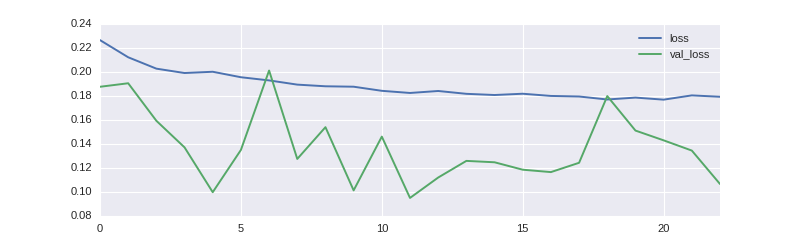

In [36]:
pd.DataFrame(history.history).plot(figsize=(10, 3))

Для проверочной выборки построим прогноз

In [35]:
model.load_weights("./lstm.multi.UpAndDown.{:d}-{:d}.hdf5".format(n_hidden[0], n_hidden[1]))
model.reset_states()
y_pred = model.predict(X_validation, batch_size=batch_size)
pred_scaled = pd.DataFrame(index=validation_dataset.index[window_size:window_size + y_pred.shape[0]*y_pred.shape[1]])
for i in range(K):
    pred_scaled[train.columns[i]] = y_pred[:, :, i].reshape(-1)

Визуализируем прогноз на валидационной выборке и построим график средней ошибки прогноза по всем измерениям

In [69]:
def plot_forecast_with_error(true, pred, error, threshold):
    f, ax = plt.subplots(len(columns_to_plot) + 1, figsize=(15, 2*len(columns_to_plot)), sharex=True)
    
    for i, column in enumerate(true.columns):
        true[column].plot(ax=ax[i], color='blue', label=None)
        pred[column].plot(ax=ax[i], color='green', label=None)
    error.plot(ax=ax[-1], color='red', label='mean_error')
    pd.Series(data=[threshold]*len(true.index), index=true.index).plot(ax=ax[-1], color='orange', label='threshold')

<IPython.core.display.Javascript object>


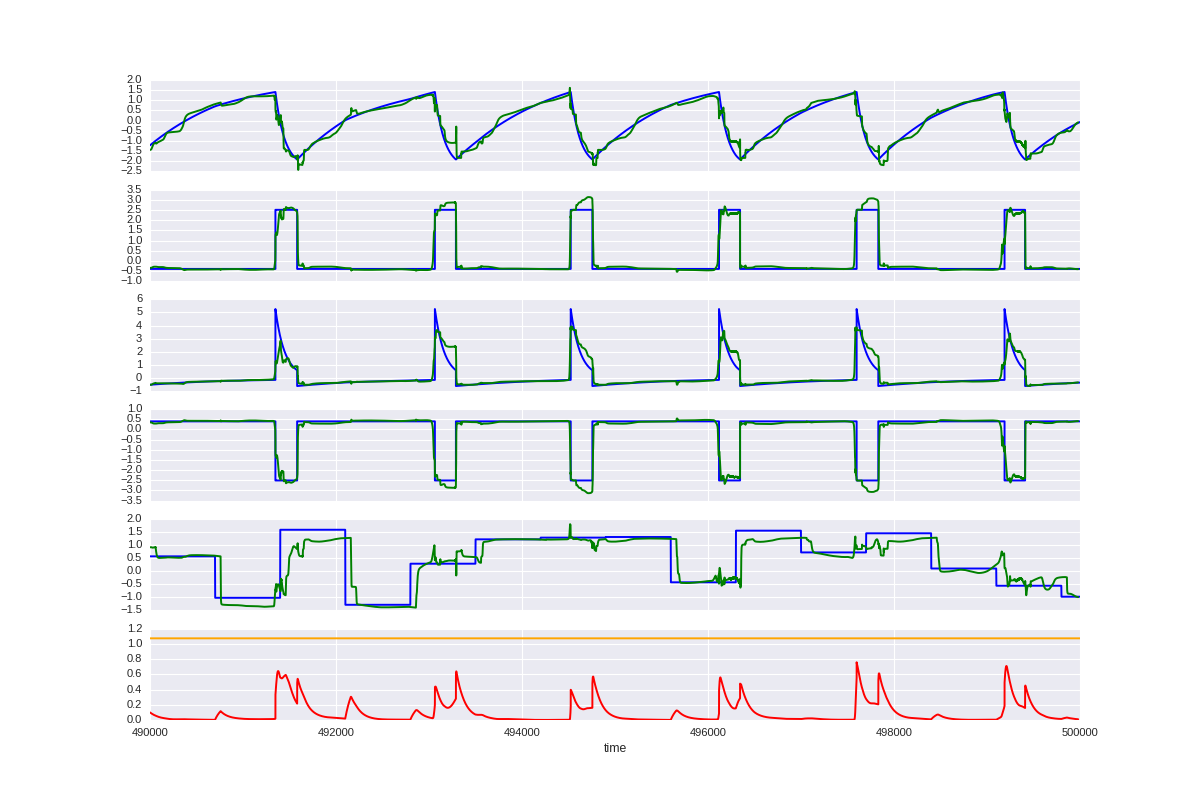

In [70]:
start_plot = 490000
end_plot = 500000
error = ((validation_dataset.iloc[window_size:window_size + y_pred.shape[0]*y_pred.shape[1]] - pred_scaled)**2).ewm(halflife=window_size).mean()
mean_error = error.mean(axis=1)
threshold = mean_error.quantile(0.999)
plot_forecast_with_error(validation_dataset[columns_to_plot][start_plot:end_plot],
                         pred_scaled[columns_to_plot][start_plot:end_plot],
                         mean_error[start_plot:end_plot],
                         threshold)

Определим порог принятия решения как 0.999 квантиль от ошибки на валидации

In [42]:

print("{:.3g}".format(threshold))

1.07


умноженный на

In [76]:
alpha = 1.0
threshold_level = alpha*threshold

### Тестирование алгоритма обнаружения атаки

Загрузим данные, содержащие последствия атаки и сделаем предобработку

In [66]:
test = pd.read_csv('/media/volume/datasets/UpAndDown/1/test6.csv', index_col='time')
test_scaled = pd.DataFrame(data=standart_scaler.transform(test), index=test.index, columns=test.columns)
test_reshaped = crop(test_scaled, window_size)
X_test = test_reshaped[:-1]

Построим прогноз для проверочного набора

In [67]:
model.reset_states()
test_pred = model.predict(X_test, batch_size=batch_size)
test_pred_scaled = pd.DataFrame(index=test.index[window_size:window_size + test_pred.shape[0]*test_pred.shape[1]])
for i in range(K):
    test_pred_scaled[train.columns[i]] = test_pred[:, :, i].reshape(-1)

И визуализируем результат

<IPython.core.display.Javascript object>


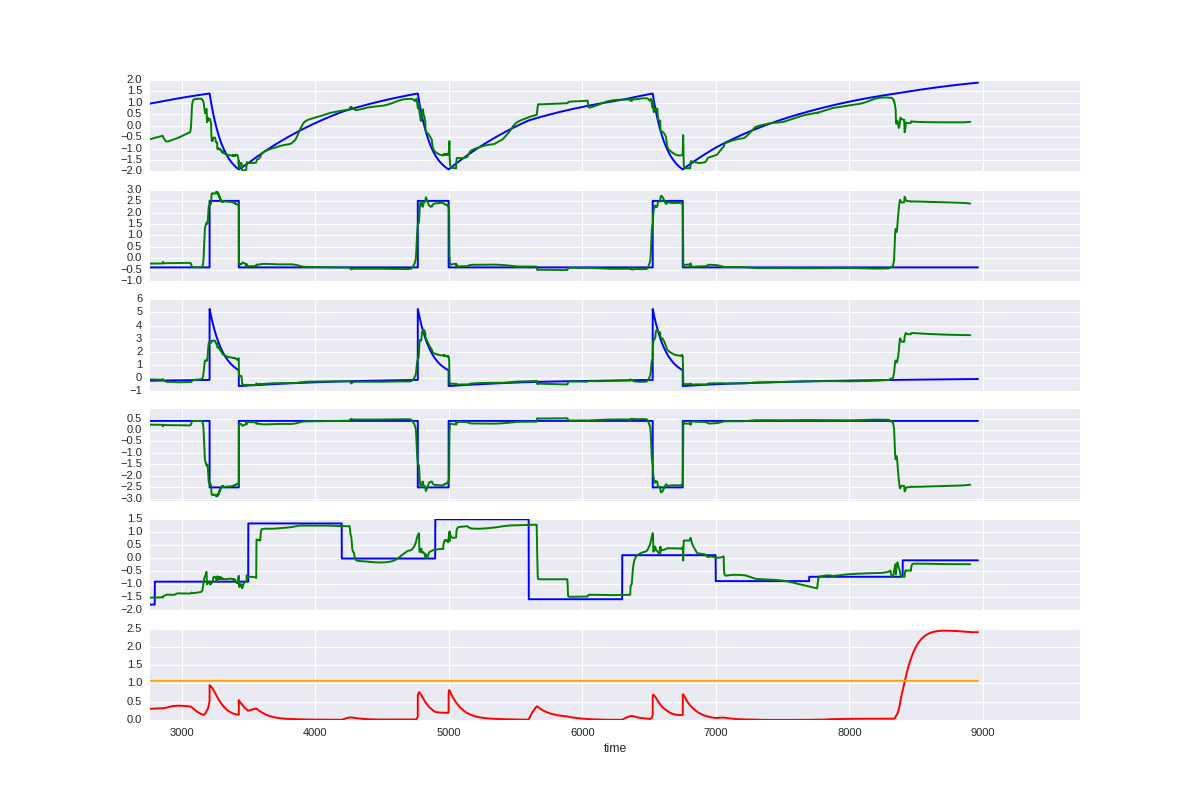

In [77]:
start_plot = test.first_valid_index() + 2000
end_plot = test.last_valid_index()
error = ((test_scaled.iloc[window_size:window_size + test_pred_scaled.shape[0]*test_pred_scaled.shape[1]] - test_pred_scaled)**2).ewm(halflife=window_size).mean()
test_mean_error = error.mean(axis=1)

plot_forecast_with_error(test_scaled[columns_to_plot][start_plot:],
                         test_pred_scaled[columns_to_plot][start_plot:],
                         test_mean_error[start_plot:],
                         threshold_level)